### Import Packages

In [52]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [53]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


### CONSTANTS

In [54]:
DATA_DIR = "./data"
IMG_DIR = f"{DATA_DIR}/all"
AUG_IMG_DIR = f"{DATA_DIR}/augmented_images"
TEST_IMG_DIR = f"{DATA_DIR}/TEST"
LABELS_PATH = "./data/CarLicensePlateDetection/annotations/*.xml"
MODEL_DIR = "./model/resnet"

IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20

### Parse image labels from .xml and .txt

In [55]:
# TMP_IMG_DIR = "./data/License Plate Detection Dataset/images/val"
# LABEL_DIR = "./data/License Plate Detection Dataset/labels/val"

# labels_dict = dict(filepath=[], xmin=[], xmax=[], ymin=[], ymax=[])
# path = glob(f"{TMP_IMG_DIR}/*.jpg")

# for file_path in path:
#     file_name = file_path.split("/")[-1]
#     label_file_name = file_name.replace("jpg", "txt")

#     img = cv2.imread(file_path)
#     img_height, img_width, _ = img.shape

#     with open(f"{LABEL_DIR}/{label_file_name}", "r") as f:
#         lines = f.readlines()

#         for line in lines:
#             # 解析 YOLO 標註內容
#             class_label, x_center, y_center, width, height = map(float, line.strip().split())

#             # 計算 xmin, xmax, ymin, ymax
#             xmin = int((x_center - width / 2) * img_width)
#             xmax = int((x_center + width / 2) * img_width)
#             ymin = int((y_center - height / 2) * img_height)
#             ymax = int((y_center + height / 2) * img_height)

#             # 添加到字典
#             labels_dict['filepath'].append(f"{IMG_DIR}/{file_name}")
#             labels_dict['xmin'].append(xmin)
#             labels_dict['xmax'].append(xmax)
#             labels_dict['ymin'].append(ymin)
#             labels_dict['ymax'].append(ymax)
# df = pd.DataFrame(labels_dict)
# df.to_csv(f"{DATA_DIR}/labels_4.csv",index=False)
# df.head()

In [56]:
# path = glob(LABELS_PATH)
# labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
# for filename in path:
#     info = xet.parse(filename)
#     root = info.getroot()
#     member_object = root.find('object')
#     file_name = root.find('filename').text
#     labels_info = member_object.find('bndbox')
#     xmin = int(labels_info.find('xmin').text)
#     xmax = int(labels_info.find('xmax').text)
#     ymin = int(labels_info.find('ymin').text)
#     ymax = int(labels_info.find('ymax').text)

#     labels_dict['filepath'].append(f"{IMG_DIR}/{file_name}")
#     labels_dict['xmin'].append(xmin)
#     labels_dict['xmax'].append(xmax)
#     labels_dict['ymin'].append(ymin)
#     labels_dict['ymax'].append(ymax)

# df = pd.DataFrame(labels_dict)
# df.to_csv(f"{DATA_DIR}/labels_2.csv",index=False)
# df.head()

In [57]:
# def getFilename(filename):
#     filename_image = xet.parse(filename).getroot().find('filename').text
#     filepath_image = os.path.join(IMG_DIR, filename_image)
#     return filepath_image

# image_path = list(df['filepath'].apply(getFilename))
# image_path[:10] #random check

In [58]:
df = pd.read_csv("./data/labels.csv")
df = df[df['xmax'] - df['xmin'] >= 80] # 過濾掉 xmax - xmin < 80 的照片
df = df.sample(frac=1).reset_index(drop=True)

# 取出 10% 作為測試集
test_ratio = 0.1
test_size = int(len(df) * test_ratio)
test_df = df[:test_size]

# 剩下的資料作為訓練和驗證資料
train_val_df = df[test_size:]

display(train_val_df.head())
image_path = list(train_val_df['filepath'])
image_path[:10] #random check

filepath  xmin  xmax  ymin  ymax
331  ./data/all/be4ca553d88676fb.jpg   695   879   463   515
332  ./data/all/4b763a824d1c62c4.jpg   911  1008   665   698
333  ./data/all/36e1293915bb2033.jpg   131   928   117   565
334           ./data/all/Cars255.png   116   273   156   188
335  ./data/all/de212da34186f795.jpg   728   853   632   706

['./data/all/be4ca553d88676fb.jpg',
 './data/all/4b763a824d1c62c4.jpg',
 './data/all/36e1293915bb2033.jpg',
 './data/all/Cars255.png',
 './data/all/de212da34186f795.jpg',
 './data/all/3c9ccd0c8a83bbc2.jpg',
 './data/all/7673862c7d077020.jpg',
 './data/all/fda2aebacc12233a.jpg',
 './data/all/2ede22b19343c52a.jpg',
 './data/all/a88ab1330ccea754.jpg']

### Data example

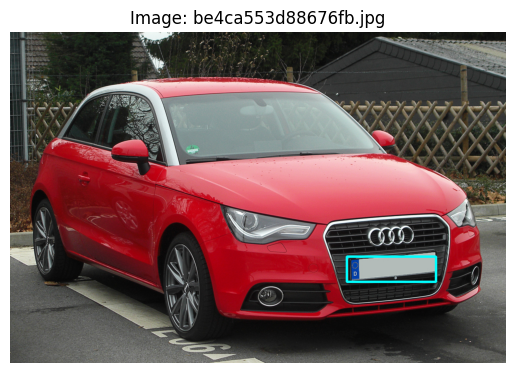

In [59]:
file_path = image_path[0]
xmin, xmax, ymin, ymax = train_val_df.iloc[0][1:]
np_img = cv2.imread(file_path)
np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
cv2.rectangle(np_img, (xmin, ymin), (xmax, ymax), (0, 255, 255), 3)
plt.imshow(np_img)
plt.title(f"Image: {os.path.basename(file_path)}")
plt.axis("off")
plt.show()

### Data Preprocessing

In [60]:
labels = train_val_df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    img_arr = cv2.imread(image_path[ind])
    h,w,d = img_arr.shape
    image = cv2.resize(img_arr, dsize=[IMAGE_SIZE, IMAGE_SIZE])

    # Normalization to labels
    xmin, xmax, ymin, ymax = labels[ind]
    nxmin, nxmax = xmin / w, xmax / w
    nymin, nymax = ymin / h, ymax / h
    label_norm = (nxmin, nxmax, nymin, nymax) # Normalized output
    
    # Append
    data.append(image)
    output.append(label_norm)

### Split train and test set

In [61]:
# Convert data to array
X = np.array(data, dtype=np.float32)
y = np.array(output, dtype=np.float32)

# Split the data into training and testing set using sklearn.
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.8,random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, test_df.shape

((2387, 224, 224, 3), (597, 224, 224, 3), (2387, 4), (597, 4), (331, 5))

### Model - ResNet152V2

In [62]:
resnet_base = ResNet152V2(
    weights="imagenet",
    include_top=False,
)

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Normalize the images to [-1, 1]
x = preprocess_input(img_inputs)

x = resnet_base(img_inputs)

# Detection head
x = layers.Flatten()(x)
x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(250, activation="relu")(x)
outputs = layers.Dense(4, activation='sigmoid')(x)

model = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO_with_ResNet")

In [63]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6))
model.summary(show_trainable=True)

Model: "YOLO_with_ResNet"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  Y          
                                                                            
 flatten_1 (Flatten)         (None, 100352)            0         Y          
                                                                            
 dense_3 (Dense)             (None, 500)               50176500  Y          
                                                                            
 dense_4 (Dense)             (None, 250)               125250    Y          
                                                                            
 dense_5 (Dense)             (None, 4)            

### Training and save model

In [64]:
model_file = f"{MODEL_DIR}/object_detection.keras"
model = keras.models.load_model(model_file)

In [65]:
EPOCHS = 10
model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
)

Epoch 1/10
150/150 [==============================] - 82s 193ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 2/10
150/150 [==============================] - 27s 179ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 3/10
150/150 [==============================] - 27s 179ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 4/10
150/150 [==============================] - 27s 180ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 5/10
150/150 [==============================] - 27s 180ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 6/10
150/150 [==============================] - 27s 180ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 7/10
150/150 [==============================] - 27s 181ms/step - loss: 0.0032 - val_loss: 0.0065
Epoch 8/10
150/150 [==============================] - 27s 181ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 9/10
150/150 [==============================] - 27s 181ms/step - loss: 0.0032 - val_loss: 0.0064
Epoch 10/10
150/150 [==============================] - 27s 181ms/step - l

In [66]:
model.save(model_file)

### Make Prediction

In [67]:
model = keras.models.load_model(model_file)

In [68]:
# Create pipeline
path = f"{TEST_IMG_DIR}/TEST1.png"
def object_detection(path):
    
    # Prepprocesing
    original_img = cv2.imread(path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    # original_img = np.array(original_img, dtype=np.uint8) # 8 bit array (0,255)
    resized_img = cv2.resize(original_img, dsize=(IMAGE_SIZE, IMAGE_SIZE))
    test_arr = resized_img[np.newaxis, ...]
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    h, w, d = original_img.shape
    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax, ymin, ymax = coords[0]
    pt1 =(xmin, ymin)
    pt2 =(xmax, ymax)
    print(pt1, pt2)
    cv2.rectangle(original_img, pt1, pt2, (0, 255, 0), 3)
    return original_img, coords[0]

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title=f"{os.path.basename(path)} prediction")

1/1 [==============================] - 2s 2s/step
(461, 326) (739, 415)


### Extract ROI

In [69]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.array(img, dtype=np.uint8)
xmin, xmax, ymin, ymax = cods
roi = img[ymin:ymax, xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title="Cropped image")

### Extract text from ROI

In [70]:
import easyocr

# 初始化 EasyOCR 的 Reader（設定語言，例如 'en' 是英文）
reader = easyocr.Reader(['en'])  

# 從圖片中提取文字
results = reader.readtext(roi, detail=0)  # detail=0 只返回文字內容

# 將結果合併成一個文字串並列印
text = ' '.join(results)
print(text)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


SN66 XMZ


### Demo

1/1 [==============================] - 0s 49ms/step
(278, 353) (605, 418)
1/1 [==============================] - 0s 49ms/step
(273, 194) (413, 235)
1/1 [==============================] - 0s 49ms/step
(137, 211) (278, 245)
1/1 [==============================] - 0s 48ms/step
(102, 415) (213, 495)
1/1 [==============================] - 0s 42ms/step
(337, 730) (446, 763)
1/1 [==============================] - 0s 51ms/step
(333, 642) (687, 799)
1/1 [==============================] - 0s 56ms/step
(706, 530) (814, 579)
1/1 [==============================] - 0s 53ms/step
(723, 616) (921, 695)
1/1 [==============================] - 0s 53ms/step
(285, 388) (411, 435)


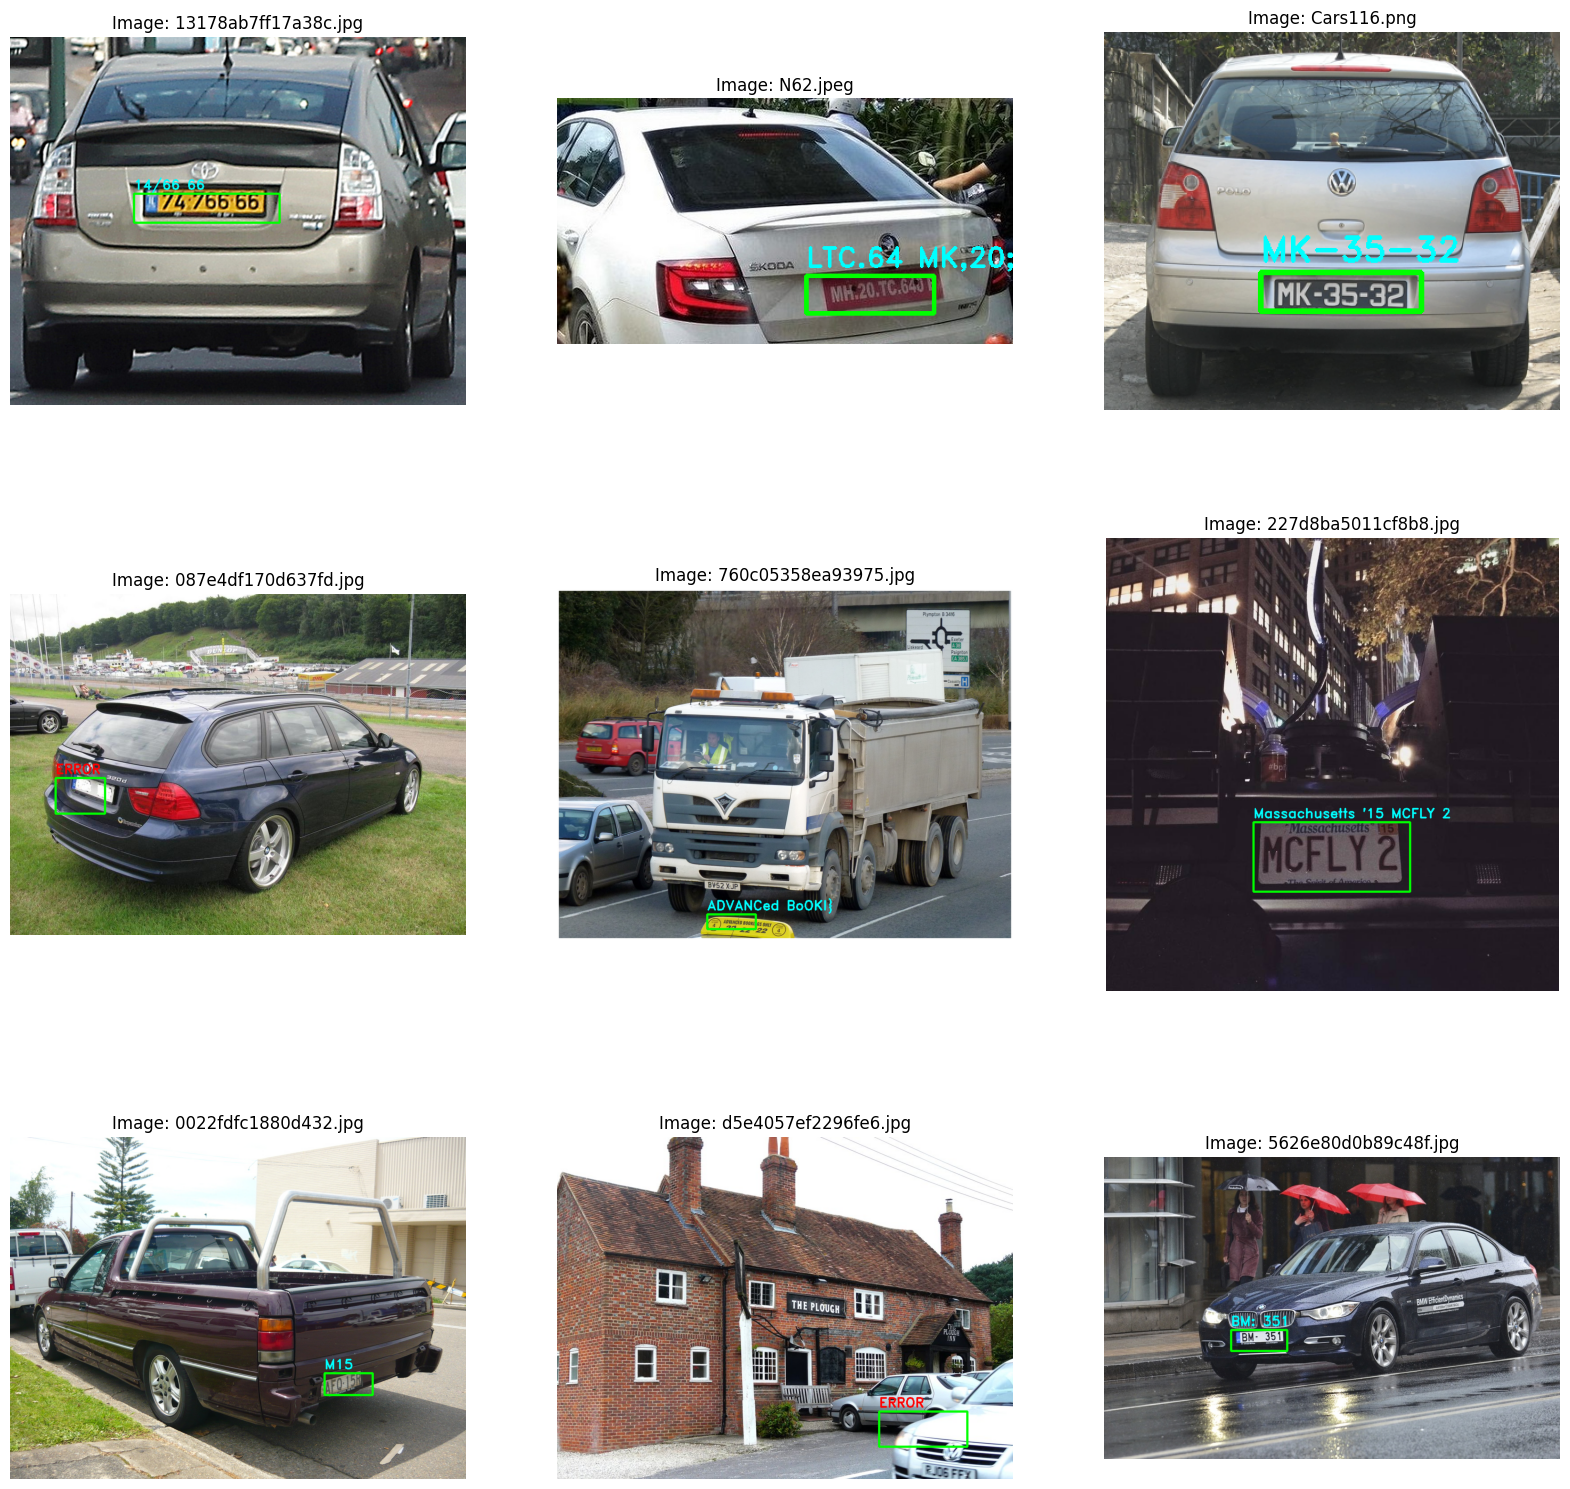

In [76]:
import random

img_cnt = 9
# image_dir = './data/CarLicensePlateDetection/images'
# all_image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
all_image_paths = list(test_df["filepath"])
selected_images = random.sample(all_image_paths, img_cnt)

fig, axes = plt.subplots(3, 3, figsize=(20,20))
axes = axes.flatten()
for ax, img_path in zip(axes, selected_images):
    output_image, cods = object_detection(img_path)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xmin, xmax, ymin, ymax = cods
    roi = img[ymin:ymax, xmin:xmax]
    results = reader.readtext(roi, detail=0)
    text = ' '.join(results)
    if text:
        cv2.putText(output_image, text, (xmin, ymin-10), 2, 1, (0, 255, 255), 2)
    else:
        cv2.putText(output_image, "ERROR", (xmin, ymin-10), 2, 1, (255, 0, 0), 2)

    ax.imshow(output_image)
    ax.set_title(f"Image: {os.path.basename(img_path)}")
    ax.axis('off')
plt.show()